In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Twitter
from gensim.corpora.dictionary import Dictionary
from gensim import models
import os
import csv
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

In [2]:
# 1. 뉴스 기사 크롤링 및CSV 저장 함수

def get_news(date):
    up_url = 'https://finance.naver.com/news/mainnews.nhn?date='+date
    domain = 'https://finance.naver.com'
    up_raw = requests.get(up_url)
    up_soup = BeautifulSoup(up_raw.text, 'html.parser')
    up_articles = up_soup.select('div.mainNewsList a[href]')
    urls=[]
    result=[['날짜','제목','본문']]
    for ar in up_articles:
        
        try:
            url=domain+ar["href"]
            raw = requests.get(url)
            soup = BeautifulSoup(raw.text, 'html.parser')
        
            #기사 제목 구하기
            sub = soup.select('div.article_info > h3')[0].get_text()
            sub = sub.replace("\n", "")
            sub = sub.replace("\t", "")
        
            #기사 본문 구하기
            main = soup.select('div.articleCont')[0]
            if main.select('div'): main.div.decompose()
            main=main.get_text()
            main = main.replace("\t", "")
            main = main.replace("\n", "")
        
        except:
            continue
    
        result.append([date,sub,main])
    
    df = pd.DataFrame(result)
    df.drop_duplicates().to_csv("./csv/"+date+".csv", index=False, header=False)

In [3]:
# 2017년 ~ 2020년 지수 데이터 불러오기
df_index = pd.read_csv("./index.csv", sep=",")
df_index=df_index[["일자","등락률(%)"]]
day_list=df_index["일자"]

In [126]:
# 불러온 데이터 기간만큼의 기사 크롤링
for day in day_list:
    get_news(day)

In [128]:
#불용어 사전 불러오기
with open("./stopwords.txt", encoding='utf-8-sig') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

#기사 불러오기 및 형태소 추출
path='./csv/'
file_list=os.listdir(path)
nouns=[]
spliter = Twitter()

for file in file_list:
    df=pd.read_csv(path+file)
    sen=''
    for text in df["본문"]: sen+=text+" "       
    noun =spliter.nouns(sen)
    noun = [ w for w in noun if w not in stopwords]
    noun = [ w for w in noun if len(w) > 1]
    nouns.append(noun)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [129]:
#형태소 저장
f = open("./nouns.csv","w", newline="")
csvwriter = csv.writer(f)
for row in nouns:
    csvwriter.writerow(row)
f.close()

In [4]:
#형태소 불러오기
nouns=[]
with open('./nouns.csv', 'r') as f:
    csv = csv.reader(f)
    for row in csv:
        nouns.append(row)

In [96]:
#TF-IDF값 구하기
dictionary = Dictionary(nouns)
corpus = [dictionary.doc2bow(doc) for doc in nouns]

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

#TF-IDF 값 0.1 미만 제거
refine_nouns=[]
for score_list in corpus_tfidf:
    temp=[]
    for score in score_list:
        if score[1]>0.1: 
            temp.append(dictionary[score[0]])
    refine_nouns.append(temp)
    
rerefine_nouns=[]

for i in range(len(nouns)):
    temp=[]
    for j in range(len(nouns[i])):
        if nouns[i][j] in refine_nouns[i]: temp.append(nouns[i][j])
    rerefine_nouns.append(temp)

In [106]:
# Word2Vec 트레이닝
model = models.Word2Vec(rerefine_nouns, size=5000, window=70, workers=3, sg=1, min_count=4)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


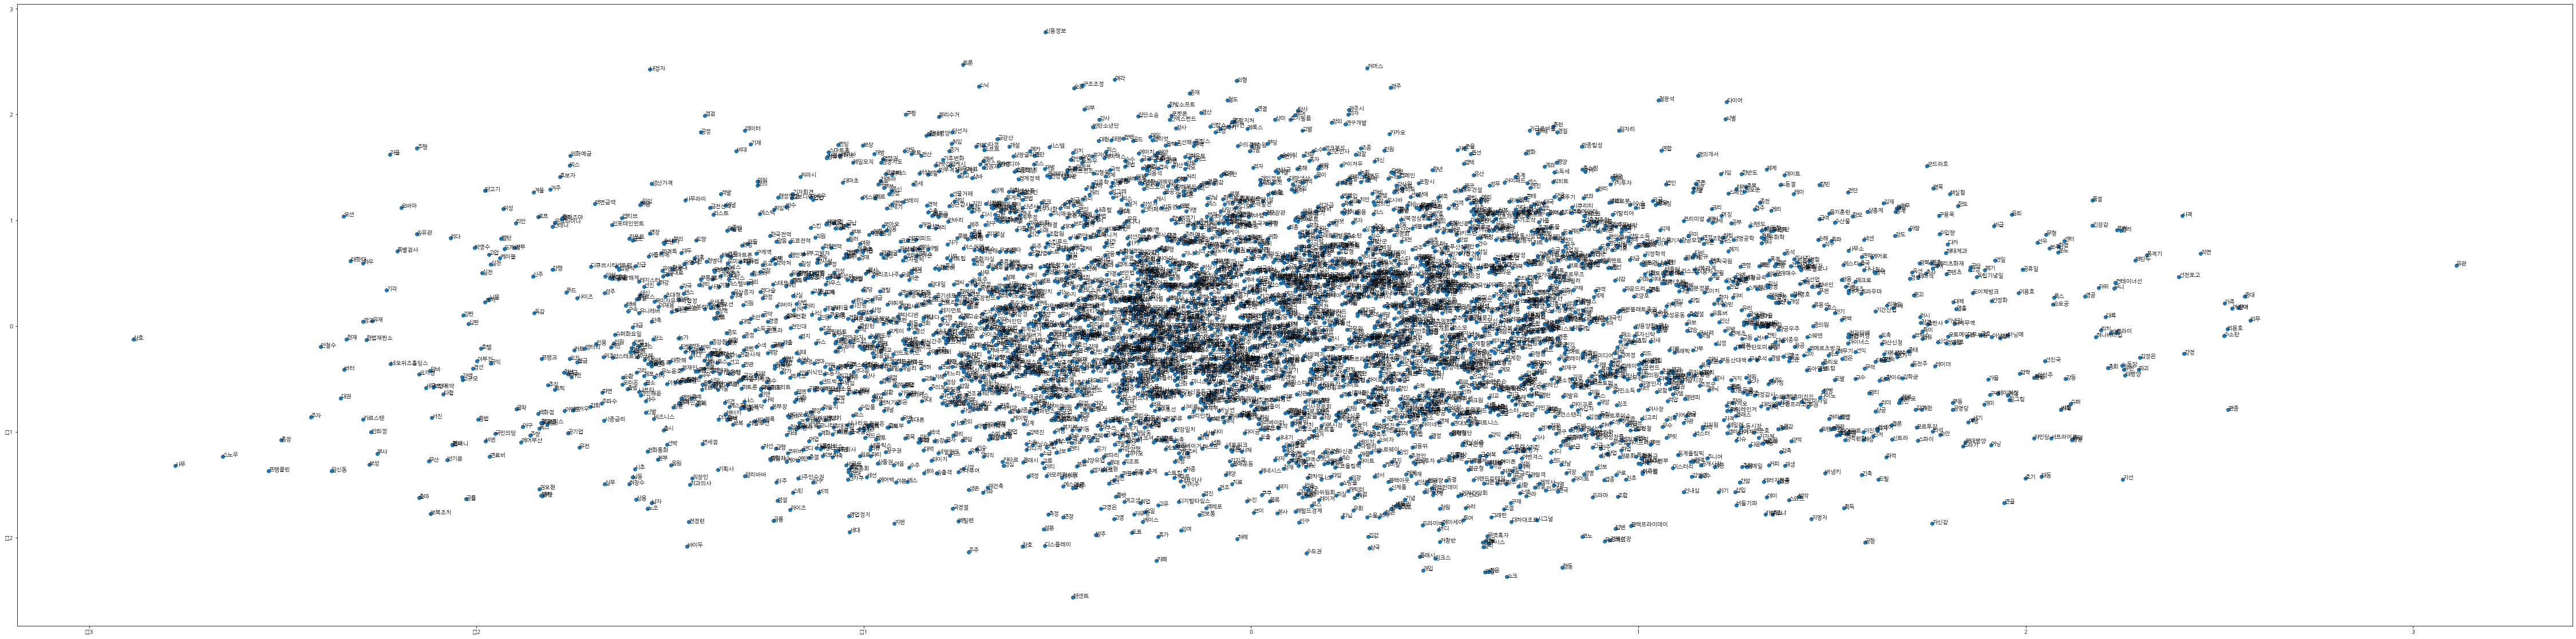

In [151]:
# Word2Vec 시각화

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm._rebuild()


plt.rc('font', family='NanumGothic')

word_vectors = model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys=xys[:,1]

def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(80,20))
    plt.scatter(xs,ys,marker='o')
    for i,v in enumerate(vocabs):
        plt.annotate(v,xy=(xs[i], ys[i]))
        
plot_2d_graph(vocabs, xs,ys)

In [108]:
#K-means 군집화
vectors=model.wv.syn0
kmeans=KMeans(3)
idx=kmeans.fit_predict(vectors)
idx=list(idx)
names = model.wv.index2word

<ipython-input-108-fcda257f649d>:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  vectors=model.wv.syn0


In [142]:
#클러스터 별로 사전 구축
index_dict1=[]
index_dict2=[]
index_dict3=[]
for i in range(len(names)):
        if idx[i]==0: index_dict1.append(names[i])
        if idx[i]==1: index_dict2.append(names[i])
        if idx[i]==2: index_dict3.append(names[i])

In [110]:
#날짜, 지수 등락 및 사전 매칭 데이터프레임 생성
dict_list=[]
for i in range(len(nouns)):
    dict1 = len(list(set(index_dict1).intersection(nouns[i])))
    dict2 = len(list(set(index_dict2).intersection(nouns[i])))
    dict3 = len(list(set(index_dict3).intersection(nouns[i])))
    if dict1 > dict2: 
        if dict1 > dict3: 
            dict_list.append('index_dict1')
        else:
            dict_list.append('index_dict3')
    elif dict2 > dict1:
        if dict2 > dict3:
            dict_list.append('index_dict2')
        else:
            dict_list.append('index_dict3')
    else:
        dict_list.append('-')
        
df_index['사전']=dict_list

In [146]:
df_index.head()

,일자,등락률(%),사전
0,2017-01-02,-0.01,index_dict3
1,2017-01-03,0.88,index_dict2
2,2017-01-04,0.08,index_dict1
3,2017-01-05,-0.18,index_dict2
4,2017-01-06,0.35,index_dict2


In [138]:
# 예측 확률 구하기
dict1=list(df_index[df_index['사전']=='index_dict1']['등락률(%)']) #상승
dict2=list(df_index[df_index['사전']=='index_dict2']['등락률(%)']) #횡보
dict3=list(df_index[df_index['사전']=='index_dict3']['등락률(%)']) #하락

count=0
for n in dict1:
    if n>0: count+=1
dict1per=count/len(dict1)

count=0
for n in dict2:
    if 0.5>n>-0.5: count+=1
dict2per=count/len(dict2)

count=0
for n in dict3:
    if n<0: count+=1
dict3per=count/len(dict3)

In [139]:
print("상승 예측 활률 : ", round(dict1per*100,2))
print("횡보 예측 활률 : ", round(dict2per*100,2))
print("하락 예측 활률 : ", round(dict3per*100,2))

상승 예측 활률 :  60.18
횡보 예측 활률 :  52.6
하락 예측 활률 :  46.68
